## ⚙️ Import Libraries

In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

%pip install keras-cv
import keras_cv

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Import other libraries
import cv2
import pandas as pd
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


## ⏳ Load the Data

In [2]:
data = np.load('/kaggle/input/balanced-augmented-dataset0-1/clean_dataset.npz')

X_train_val = data['images']
y_train_val = data['labels']

label_names = {
0: 'Basophil',
1: 'Eosinophil',
2: 'Erythroblast',
3: 'Immature granulocytes',
4: 'Lymphocyte',
5: 'Monocyte',
6: 'Neutrophil',
7: 'Platele'
}

print("Training-Validation Data Shape:", X_train_val.shape)
print("Training-Validation Label Shape:", y_train_val.shape)

# Inspect the target
print('Counting occurrences of target classes:')
print(pd.DataFrame(y_train_val, columns=['digit'])['digit'].value_counts())

Training-Validation Data Shape: (11959, 96, 96, 3)
Training-Validation Label Shape: (11959, 1)
Counting occurrences of target classes:
digit
6    2330
1    2181
3    2026
7    1643
2    1085
5     993
0     852
4     849
Name: count, dtype: int64


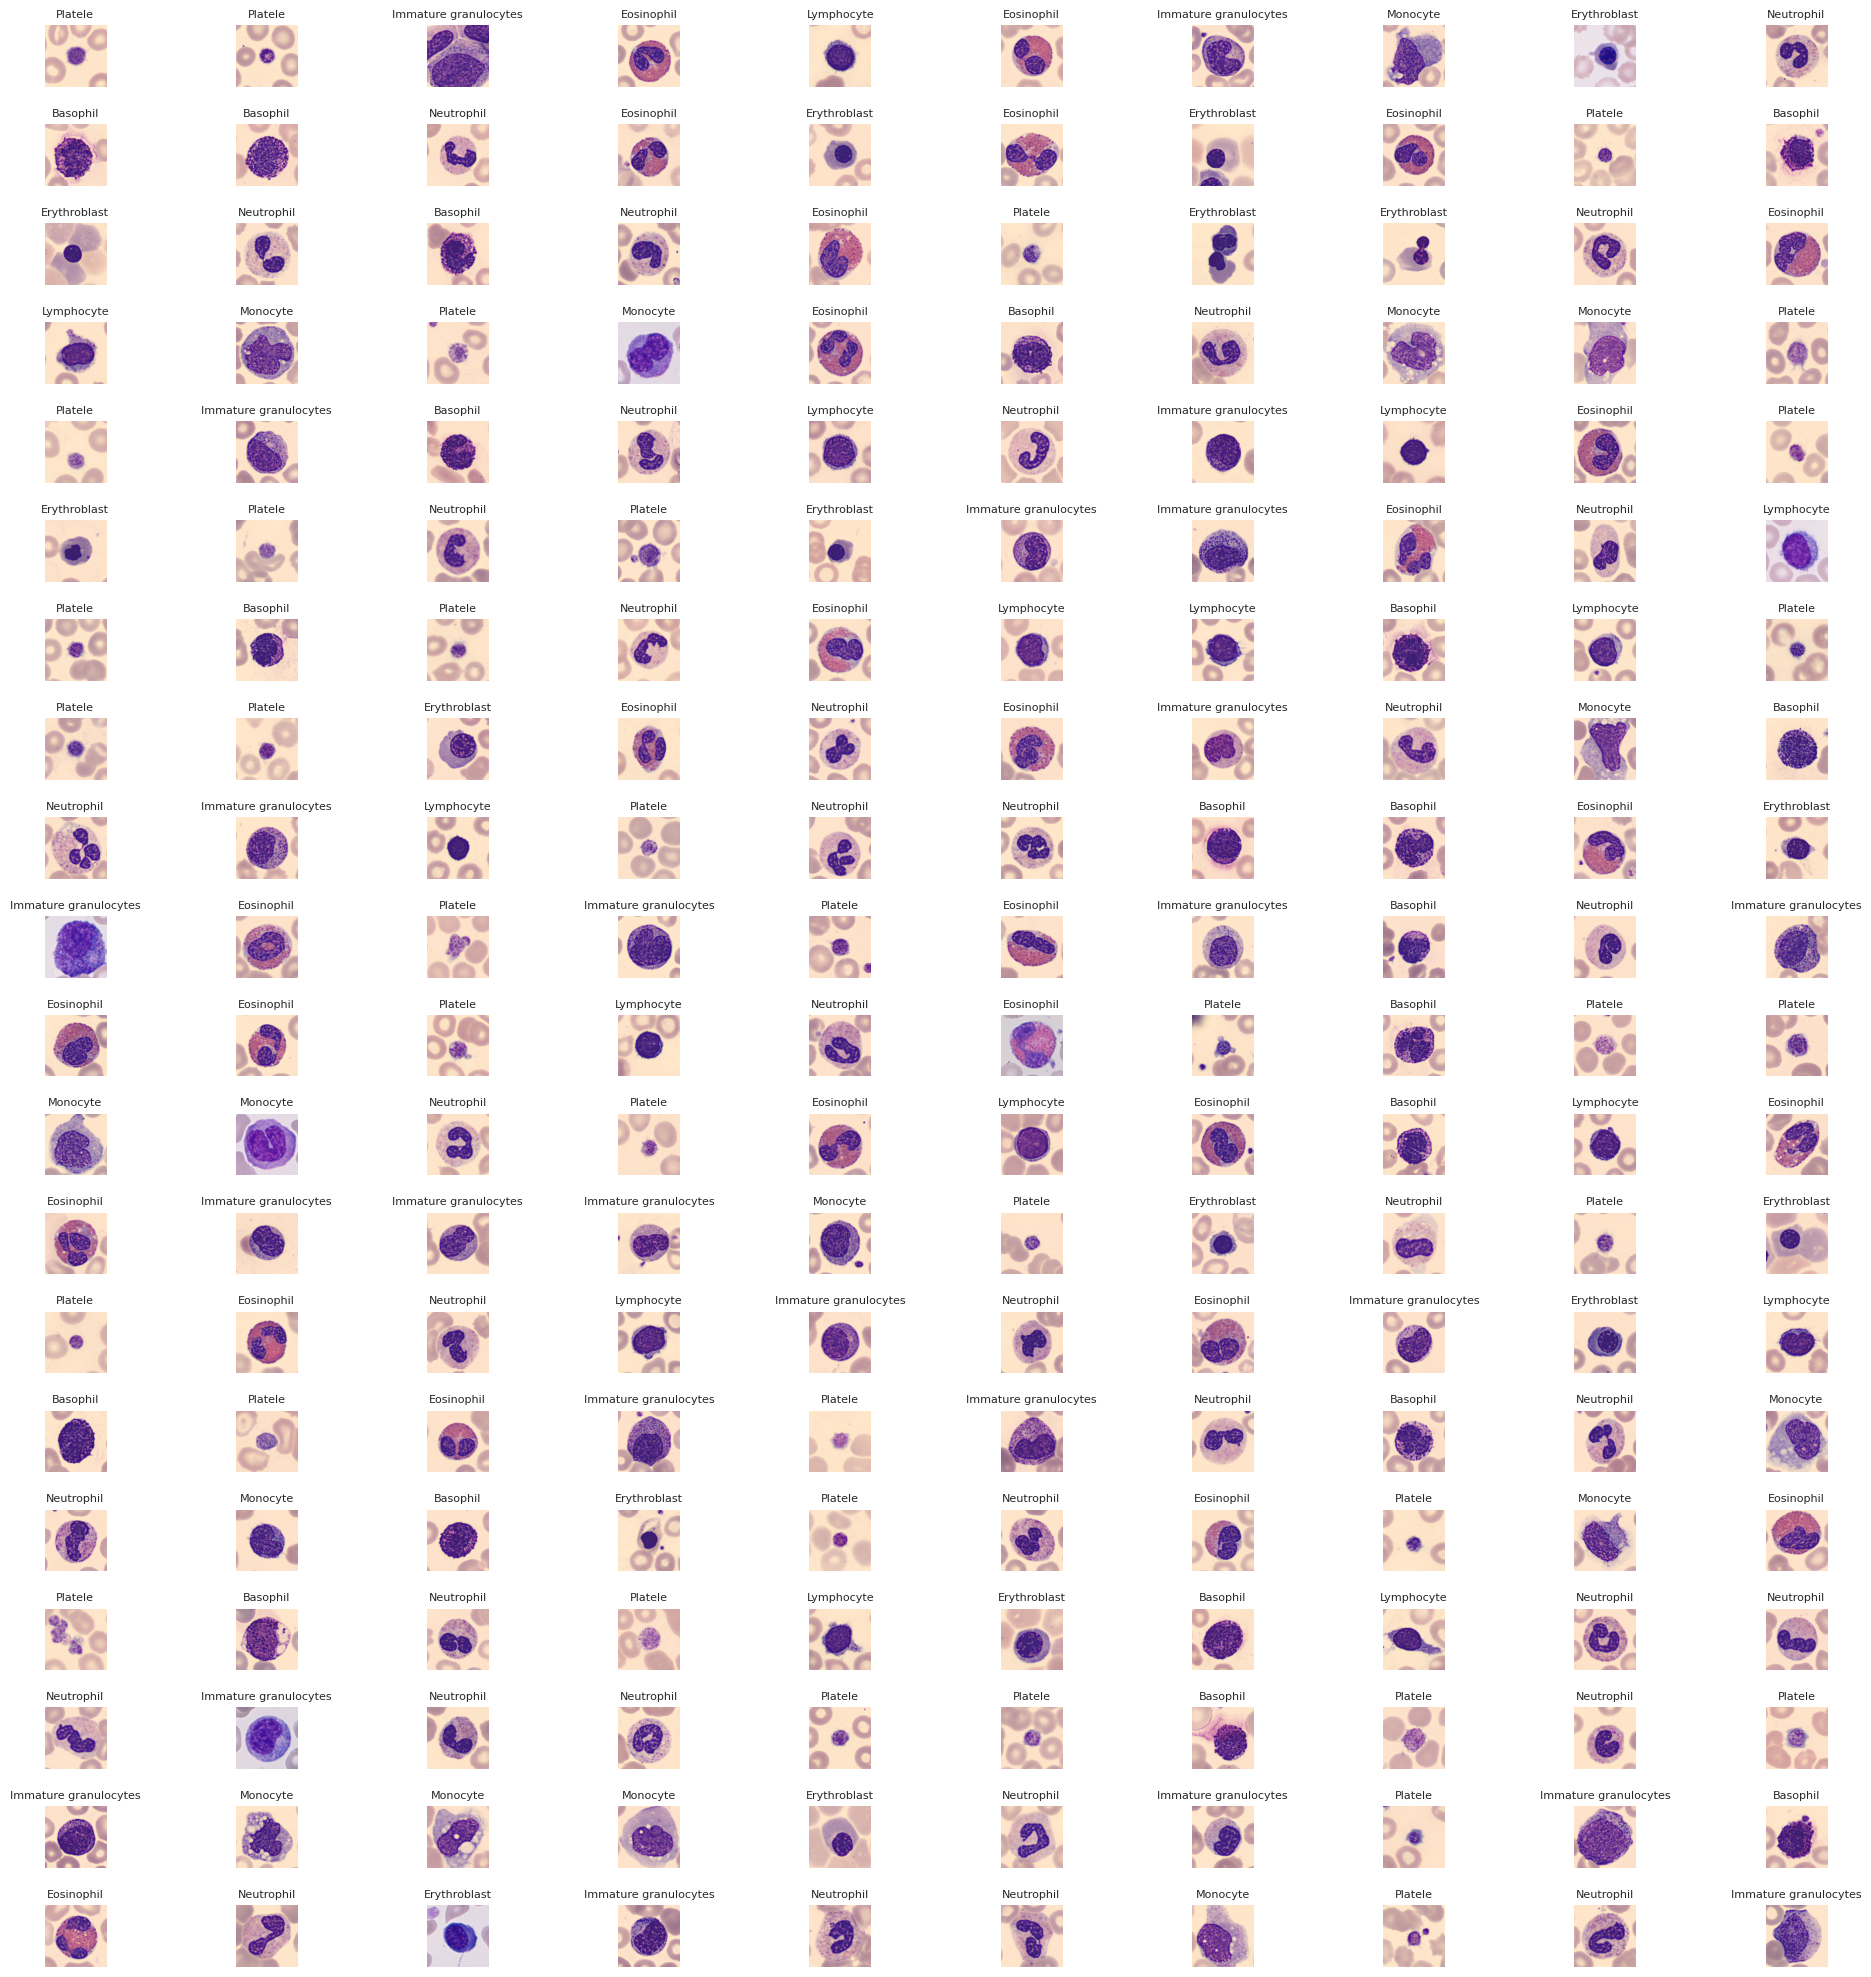

In [3]:
# Set parameters for visualization
num_images = 200  # Total number of images to display
images_per_row = 10  # Number of images per row
random_indices = random.sample(range(len(X_train_val)), num_images)

# Create a grid of subplots
fig, axes = plt.subplots(
    num_images // images_per_row, 
    images_per_row, 
    figsize=(20, 20)
)

# Flatten axes for easier iteration
axes = axes.flatten()

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i]
    ax.imshow(np.squeeze(X_train_val[idx]), vmin=0., vmax=1.)
    ax.set_title(f'{label_names[y_train_val[idx][0]]}', fontsize=8)
    ax.axis('off')

# Hide unused axes if any
for ax in axes[num_images:]:
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

# 🔄 Process Data

In [4]:
#Augmix Layer
augmix = keras_cv.layers.AugMix(
    value_range=(0,1)
)
#Rand Augment Layer
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0,1), augmentations_per_image=3, magnitude=0.5
)
#Random Hue Layer
random_hue = keras_cv.layers.RandomHue(
    factor=0.7, value_range=(0,1)
)
#Random Cutout Layer
random_cutout = keras_cv.layers.RandomCutout(0.5, 0.5)
#Random Sharpness Layer
random_sharpness = keras_cv.layers.RandomSharpness(
    factor=0.5, value_range=(0,1)
)

In [5]:
# Normalize data to the range [0, 1]
X_train_val = (X_train_val / 255).astype('float32')

## Balance and Augment classes

In [6]:
num_samples_for_class = 5000
X_augmented = np.array([])

for y in np.unique(y_train_val):
    idxs = np.where(y_train_val == y)[0]
    num_new = (num_samples_for_class - len(idxs)) // 5
    print(f'Class {y} has {len(idxs)} images, adding {num_new * 5} augmented images...')
    
    idxs_to_rand_aug = np.random.choice(idxs, size=num_new, replace=True)
    idxs_to_augmix = np.random.choice(idxs, size=num_new, replace=True)
    idxs_to_hue = np.random.choice(idxs, size=num_new, replace=True)
    idxs_to_cutout = np.random.choice(idxs, size=num_new, replace=True)
    idxs_to_sharpness = np.random.choice(idxs, size=num_new, replace=True)
    
    X_rand_aug = rand_augment(X_train_val[idxs_to_rand_aug])
    X_augmix = augmix(X_train_val[idxs_to_augmix])
    X_hue = random_hue(X_train_val[idxs_to_hue])
    X_cutout = random_cutout(X_train_val[idxs_to_cutout])
    X_sharpness = random_sharpness(X_train_val[idxs_to_sharpness])
    
    y_new = np.array([y] * (num_new*5)).reshape(-1, 1)

    X_train_val = np.vstack([X_train_val, X_rand_aug, X_augmix, X_hue, X_cutout, X_sharpness])
    y_train_val = np.vstack([y_train_val, y_new])

Class 0 has 852 images, adding 4145 augmented images...
Class 1 has 2181 images, adding 2815 augmented images...
Class 2 has 1085 images, adding 3915 augmented images...
Class 3 has 2026 images, adding 2970 augmented images...
Class 4 has 849 images, adding 4150 augmented images...
Class 5 has 993 images, adding 4005 augmented images...
Class 6 has 2330 images, adding 2670 augmented images...
Class 7 has 1643 images, adding 3355 augmented images...


In [7]:
print("Training-Validation Data Shape:", X_train_val.shape)
print("Training-Validation Label Shape:", y_train_val.shape)

# Inspect the target
print('Counting occurrences of target classes:')
print(pd.DataFrame(y_train_val, columns=['digit'])['digit'].value_counts())

Training-Validation Data Shape: (39984, 96, 96, 3)
Training-Validation Label Shape: (39984, 1)
Counting occurrences of target classes:
digit
6    5000
2    5000
4    4999
7    4998
5    4998
0    4997
3    4996
1    4996
Name: count, dtype: int64


In [8]:
# Convert labels to categorical format using one-hot encoding
y_train_val = tfk.utils.to_categorical(y_train_val)

In [9]:
#Use not balanced data
#Mixup Layer
mixup = keras_cv.layers.MixUp()
X_mixup = (data['images']/ 255).astype('float32')
y_mixup = tfk.utils.to_categorical(data['labels'])
out = mixup(
    {'images': tf.convert_to_tensor(X_mixup), 'labels': tf.convert_to_tensor(y_mixup, dtype=tf.float32)}
)

X_mixup = out['images'].numpy()
y_mixup = out['labels'].numpy()

In [10]:
X_train_val = np.vstack((X_train_val, X_mixup))
y_train_val = np.vstack((y_train_val, y_mixup))

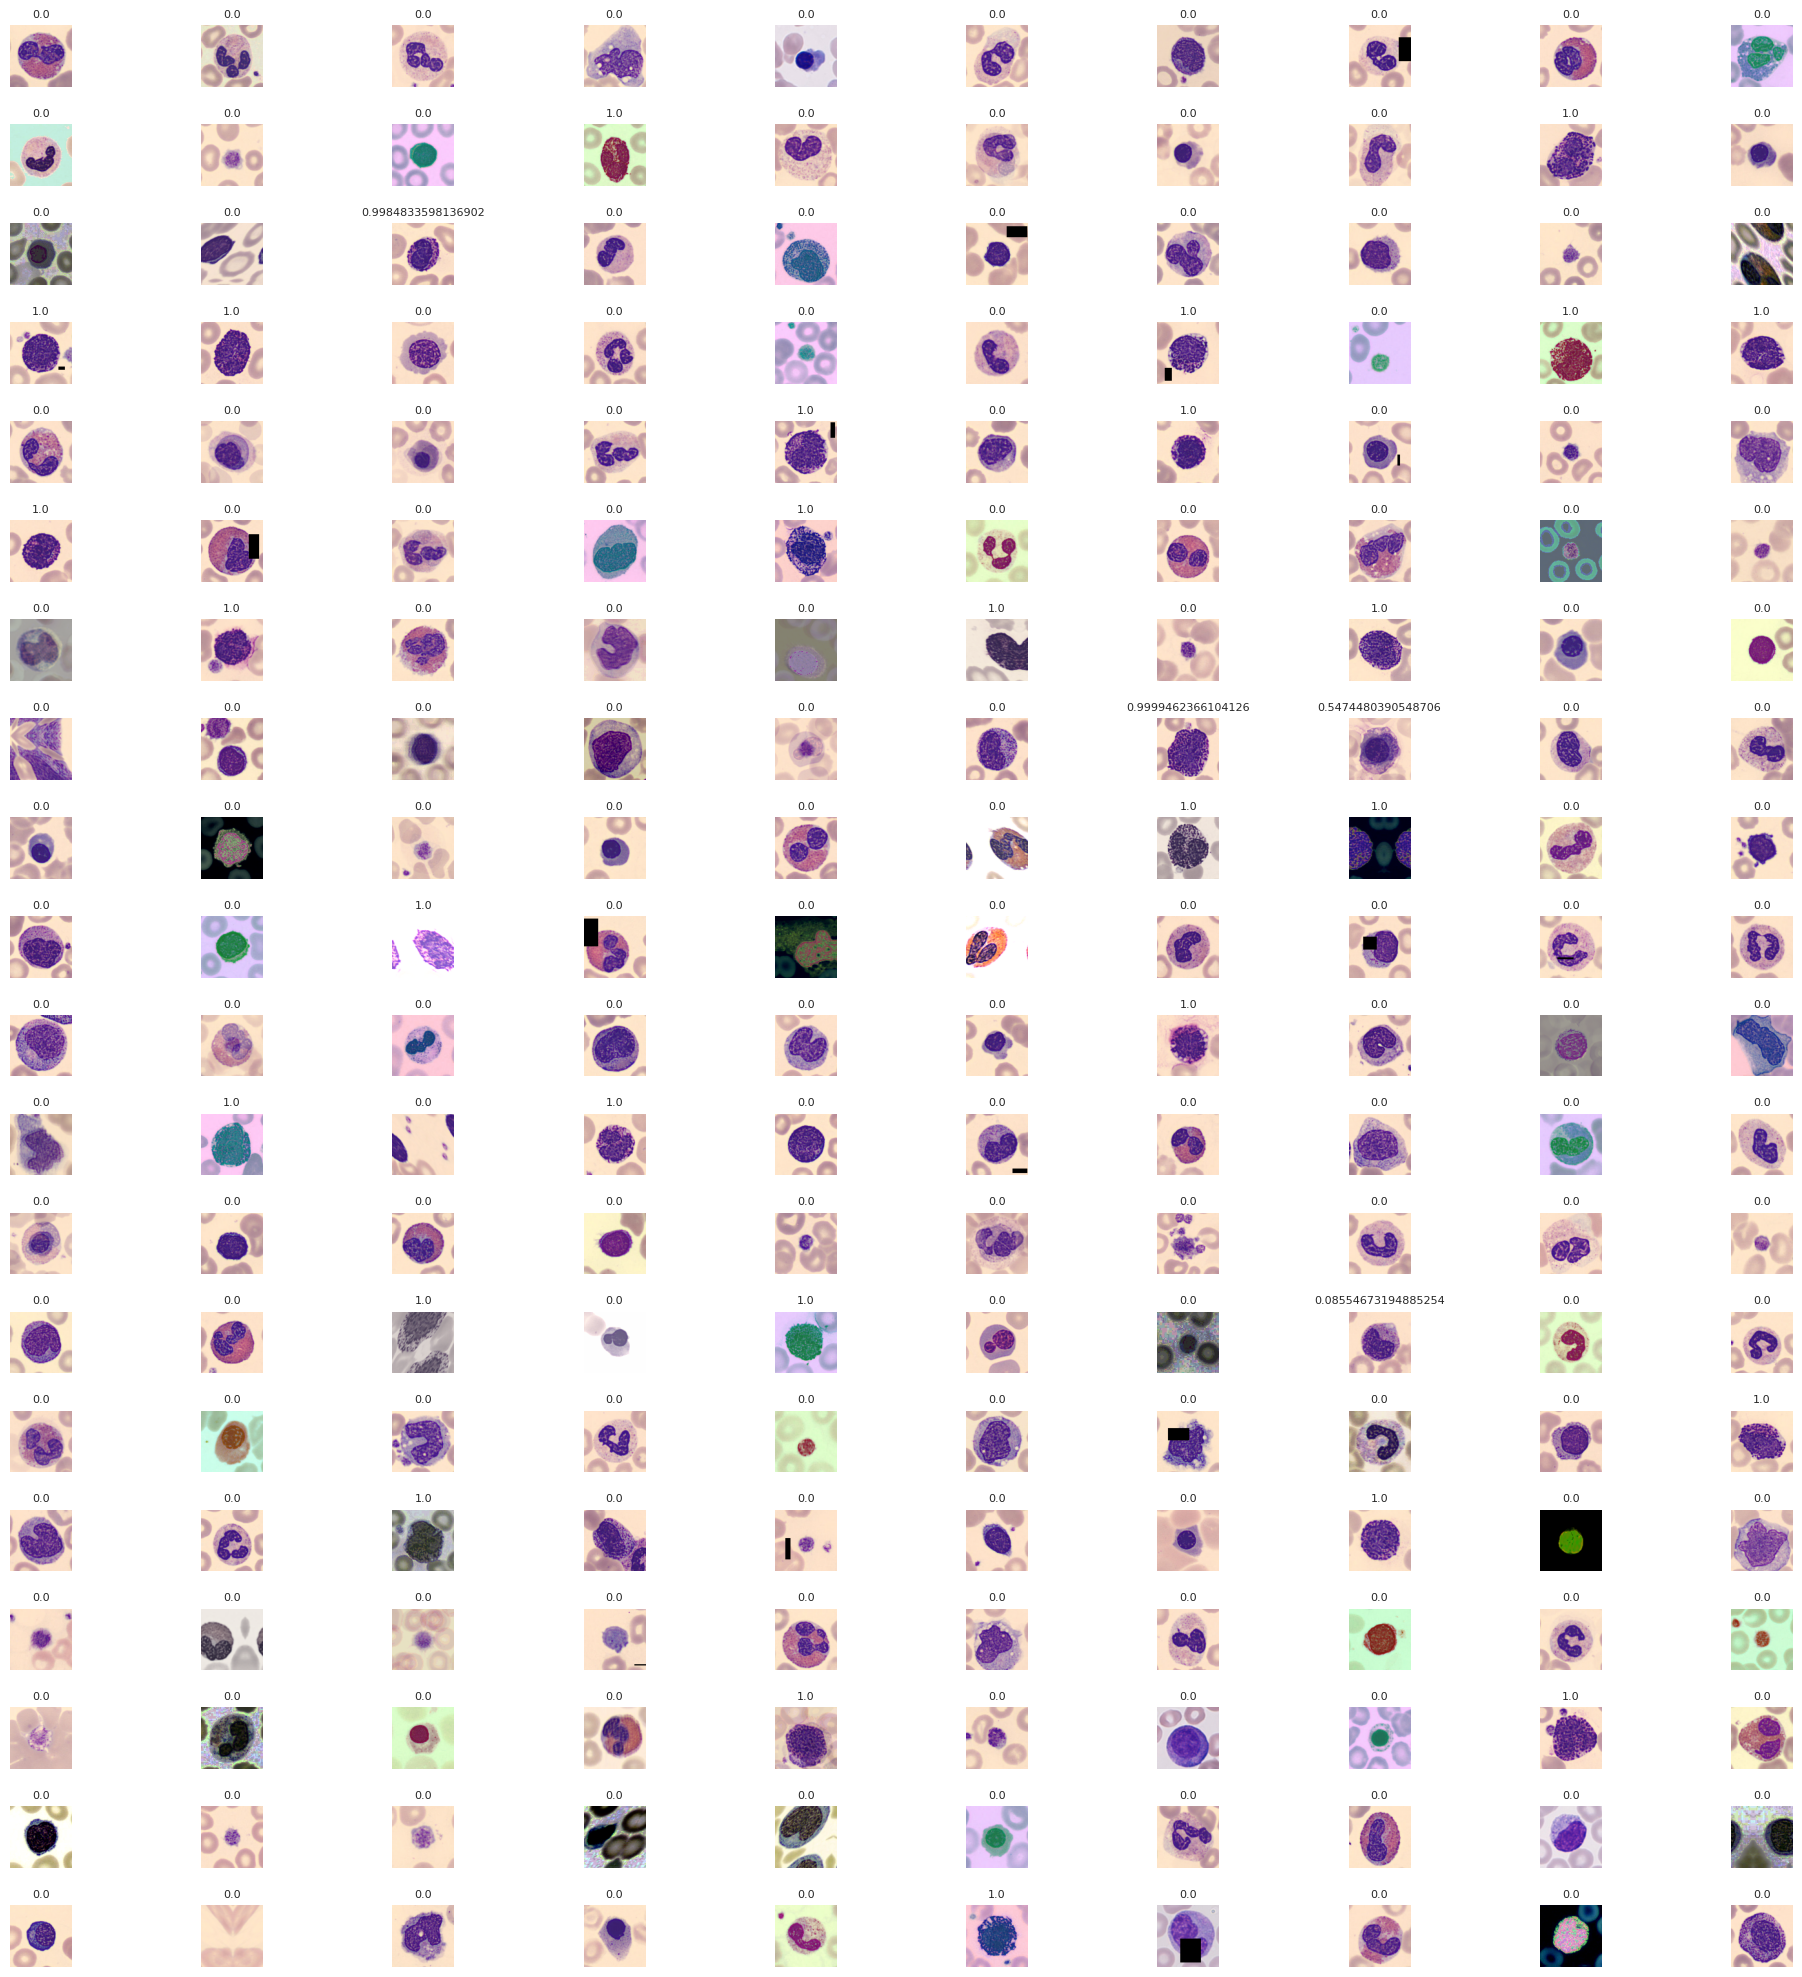

Training-Validation Data Shape: (51943, 96, 96, 3)
Training-Validation Label Shape: (51943, 8)
Counting occurrences of target classes:
digit
6    7355
1    7154
3    7043
7    6642
2    6066
5    5985
0    5867
4    5831
Name: count, dtype: int64


In [11]:
# Set parameters for visualization
num_images = 200  # Total number of images to display
images_per_row = 10  # Number of images per row
random_indices = random.sample(range(len(X_train_val)), num_images)

# Create a grid of subplots
fig, axes = plt.subplots(
    num_images // images_per_row, 
    images_per_row, 
    figsize=(20, 20)
)

# Flatten axes for easier iteration
axes = axes.flatten()

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i]
    ax.imshow(np.squeeze(X_train_val[idx]), vmin=0., vmax=1.)
    ax.set_title(f'{y_train_val[idx][0]}', fontsize=8)
    ax.axis('off')

# Hide unused axes if any
for ax in axes[num_images:]:
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

print("Training-Validation Data Shape:", X_train_val.shape)
print("Training-Validation Label Shape:", y_train_val.shape)

# Inspect the target
print('Counting occurrences of target classes:')
y_train_val_labels = np.argmax(y_train_val, axis=1)
print(pd.DataFrame(y_train_val_labels, columns=['digit'])['digit'].value_counts())

In [12]:
np.savez('balanced_augmented_dataset(0_1).npz', images=X_train_val, labels=y_train_val)

In [13]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink('balanced_augmented_dataset(0_1).npz')

/kaggle/working


/kaggle/working/balanced_augmented_dataset(0_1).npz